In [2]:
# search for optimal parameters using GridSearch CV
# documentation http://scikit-learn.org/stable/modules/grid_search.html

# read in and prepare titanic data
import pandas as pd
titanic = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT5/master/data/titanic_train.csv')
titanic['Sex'] = titanic.Sex.map({'female':0,'male':1})
titanic.Age.fillna(titanic.Age.mean(),inplace=True)
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked').iloc[:,1:]
titanic = pd.concat([titanic,embarked_dummies],axis = 1)

In [3]:
#define X and y
feature_cols = ['Pclass','Sex','Age','Embarked_Q','Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [4]:
# use cross-validation to find best max_depth
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

In [5]:
# try max_depth=2
treeclf = DecisionTreeClassifier(max_depth=2,random_state=1)
cross_val_score(treeclf,X,y,cv=10,scoring='roc_auc').mean()

0.80183585151232217

In [6]:
# try max_depth=3
treeclf = DecisionTreeClassifier(max_depth=3,random_state=1)
cross_val_score(treeclf,X,y,cv=10,scoring='roc_auc').mean()

0.84275187448716848

In [7]:
# use GridSearchCV to automate the search
from sklearn.grid_search import GridSearchCV
treeclf = DecisionTreeClassifier(random_state=1)
depth_range = range(1,21)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(treeclf, param_grid,cv=10,scoring='roc_auc')
grid.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=1, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [11]:
# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]

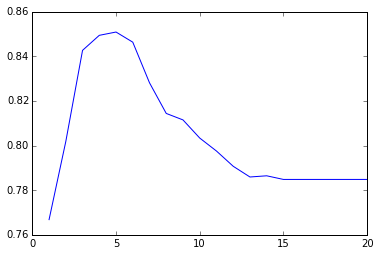

In [12]:
# plot the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(depth_range, grid_mean_scores)

In [13]:
# what was the best?
grid.best_score_
grid.best_params_
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=1, splitter='best')

In [14]:
# search a "grid" of parameters
depth_range = range(1,21)
leaf_range = range(1,11)
param_grid = dict(max_depth=depth_range,min_samples_leaf=leaf_range)
grid = GridSearchCV(treeclf,param_grid,cv=10,scoring='roc_auc')
grid.fit(X,y)
grid.best_score_
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 8}

In [15]:
# task standardization of features (aka "center and scale" or "z-score normalization")
# StandardScaler http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# fake data
train = pd.DataFrame({'id':[0,1,2], 'length':[0.9,0.3,0.6], 'mass':[0.1,0.2,0.8], 'rings':[40,50,60]})
oos = pd.DataFrame({'length':[0.59], 'mass':[0.79], 'rings':[54.9]})

# define X and y
X = train[['length','mass','rings']]
y = train.id

# KNN with k = 1
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')

In [16]:
# what "should" it predict? what does it predict?
knn.predict(oos)

array([1], dtype=int64)

In [17]:
# standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [18]:
# compare original to standardized
X.values
X_scaled

array([[ 1.22474487, -0.86266219, -1.22474487],
       [-1.22474487, -0.53916387,  0.        ],
       [ 0.        ,  1.40182605,  1.22474487]])

In [19]:
scaler.mean_

array([  0.6       ,   0.36666667,  50.        ])

In [20]:
scaler.std_

array([ 0.24494897,  0.30912062,  8.16496581])

In [22]:
(X.values-scaler.mean_)/scaler.std_

array([[ 1.22474487, -0.86266219, -1.22474487],
       [-1.22474487, -0.53916387,  0.        ],
       [ 0.        ,  1.40182605,  1.22474487]])

In [23]:
# try this on real data
wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None, usecols=[0,10,13])
wine.columns=['label', 'color', 'proline']
wine.head()
wine.describe()

,label,color,proline
count,178.000000,178.000000,178.000000
mean,1.938202,5.058090,746.893258
std,0.775035,2.318286,314.907474
min,1.000000,1.280000,278.000000
25%,1.000000,3.220000,500.500000
50%,2.000000,4.690000,673.500000
75%,3.000000,6.200000,985.000000
max,3.000000,13.000000,1680.000000


In [24]:
# define X and y
X = wine[['color','proline']]
y = wine.label

In [25]:
# split into train/test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [27]:
# standardize X_train
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [28]:
# standardize X_test
X_test_scaled = scaler.transform(X_test)

In [29]:
# is this right
X_test_scaled[:,0].mean()
X_test_scaled[:,0].std()
X_test_scaled[:,1].mean()
X_test_scaled[:,1].std()

1.1495594753303366

In [30]:
# compare KNN accuracy on original vs scaled data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.64444444444444449

In [31]:
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled,y_test)

0.8666666666666667

In [32]:
# chaining steps
# pipeline http://scikit-learn.org/stable/modules/pipeline.html

# here is proper cross-validation on the original (unscaled) data
X = wine[['color','proline']]
y = wine.label
knn = KNeighborsClassifier(n_neighbors=3)
cross_val_score(knn,X,y,cv=5,scoring='accuracy').mean()

0.71983168041991563

In [34]:
# why is this improper cross-validation on the scaled data?
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cross_val_score(knn,X_scaled,y,cv=5,scoring='accuracy').mean()

0.90104247104247115

In [35]:
# fix this using Pipeline
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=3))
cross_val_score(pipe,X,y,cv=5,scoring='accuracy').mean()

0.89516011810129448

In [37]:
# using GridSearchCV with Pipeline
neighbors_range = range(1, 21)
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range)
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(X, y)
grid.best_score_
grid.best_params_

{'kneighborsclassifier__n_neighbors': 1}